In [1]:
# model -> CatBoostRegressor
# split -> RandomSplit

In [2]:
import pandas as pd

data_path = './data/processed/mart.csv'
df_for_model = pd.read_csv(data_path)
df = df_for_model.dropna()

In [3]:
df.head()

,Unnamed: 0,drive.current_mean_15_len_10_shift,drive.current_mean_45_len_10_shift,drive.current_min_45_len_5_shift,drive.current_max_90_len_5_shift,raw_mix.consumption_mean_15_len_10_shift,raw_mix.consumption_min_45_len_5_shift,raw_mix.consumption_mean_300_len_30_shift,raw_mix.moisture_avg_mean_60_len_15_shift,temp.out_mean_25_len_5_shift,temp.inlet_mean_25_len_5_shift,temp.out_min_25_len_5_shift,temp.inlet_max_30_len_5_shift,raw_mix.lab.measure.sito_009
0,2,51.529494,51.679517,49.577049,54.287800,222.591298,209.530634,213.445890,21.019171,98.033642,390.420753,93.776390,400.857178,18.7
1,3,48.745348,49.542317,47.168049,55.591145,236.073629,228.969055,230.173581,21.024649,113.629284,438.169188,97.928474,460.056946,17.8
2,4,50.371899,50.143008,48.937222,53.058567,252.679221,250.597360,237.399122,21.057899,104.994034,454.281195,97.422127,467.001190,20.0
3,5,50.073129,50.188380,49.096207,53.323956,247.183217,246.167409,247.424506,21.039999,99.260573,442.662924,97.118317,450.508606,19.4
4,6,49.700753,49.874914,48.427967,51.495384,252.355326,250.203180,250.319439,20.094898,102.154569,438.770131,98.738640,442.175476,19.1


In [4]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Определение целевой переменной и признаков
df = df.drop(columns=['Unnamed: 0'])
target = 'raw_mix.lab.measure.sito_009'
features = df.columns[df.columns != target]

# Разделение данных
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Скалирование данных
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Построение модели
params = {'iterations': 2000,
          'learning_rate': 0.02,
          'depth': 8,
          'loss_function': 'MAE',
          'eval_metric': 'MAE',
          'random_seed': 42,
          'od_type': 'Iter',
          'od_wait': 100,
          'l2_leaf_reg': 5,
          'grow_policy': 'Lossguide',
          'verbose': 0,
          'bootstrap_type': 'Bayesian',
          'score_function': 'L2'}
model = CatBoostRegressor(**params)
model.fit(X_train_scaled, y_train)

In [6]:
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Оценка модели
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_baseline = mean_absolute_error(y_test, np.full_like(y_test, y_test.mean()))
mae_baseline_shift = mean_absolute_error(y_test[:-1], y_test[1:])

# Вычисление разностей для реальных и предсказанных значений
y_test_diff = y_test[1:].values - y_test[:-1].values
y_pred_diff = y_pred[1:] - y_pred[:-1]
# Подсчет доли сонаправленных изменений
same_direction = np.sum((y_test_diff * y_pred_diff) > 0) / len(y_test_diff)

print(f'Доля сонаправленных изменений: {same_direction:.3f}')
print(f'Mean Absolute Error Baseline: {mae_baseline}')
print(f'Mean Absolute Error Baseline shifted: {mae_baseline_shift}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
# Сохранение результатов в файл    

# Формируем словарь с результатами
results = {
    'features': list(features),
    'metrics': {
        'mae': float(mae),
        'mae_baseline': float(mae_baseline),
        'mae_baseline_shift': float(mae_baseline_shift),
        'same_direction_ratio': float(same_direction),
        'mse': float(mse)
    },
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
}

Доля сонаправленных изменений: 0.523
Mean Absolute Error Baseline: 0.9656721536351165
Mean Absolute Error Baseline shifted: 1.1934579439252333
Mean Absolute Error: 1.12570309675728
Mean Squared Error: 1.9411909269390693


In [7]:
import json

filename = f'./results/metrics/result_CatBoost_Random.json'
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

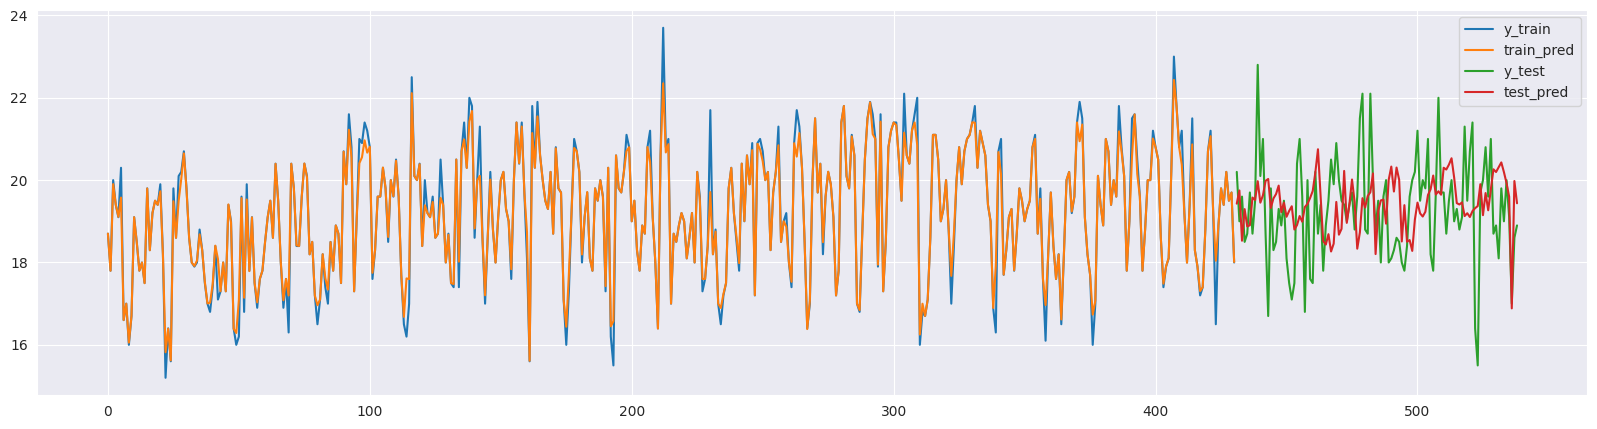

In [8]:
# Визуализация результатов
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))
y_train.plot(ax=ax, label='y_train')
pd.DataFrame(model.predict(X_train_scaled), index=y_train.index, columns=['train_pred']).plot(ax=ax)
y_test.plot(ax=ax, label='y_test')
pd.DataFrame(y_pred, index=y_test.index, columns=['test_pred']).plot(ax=ax)
ax.legend()
plt.show()

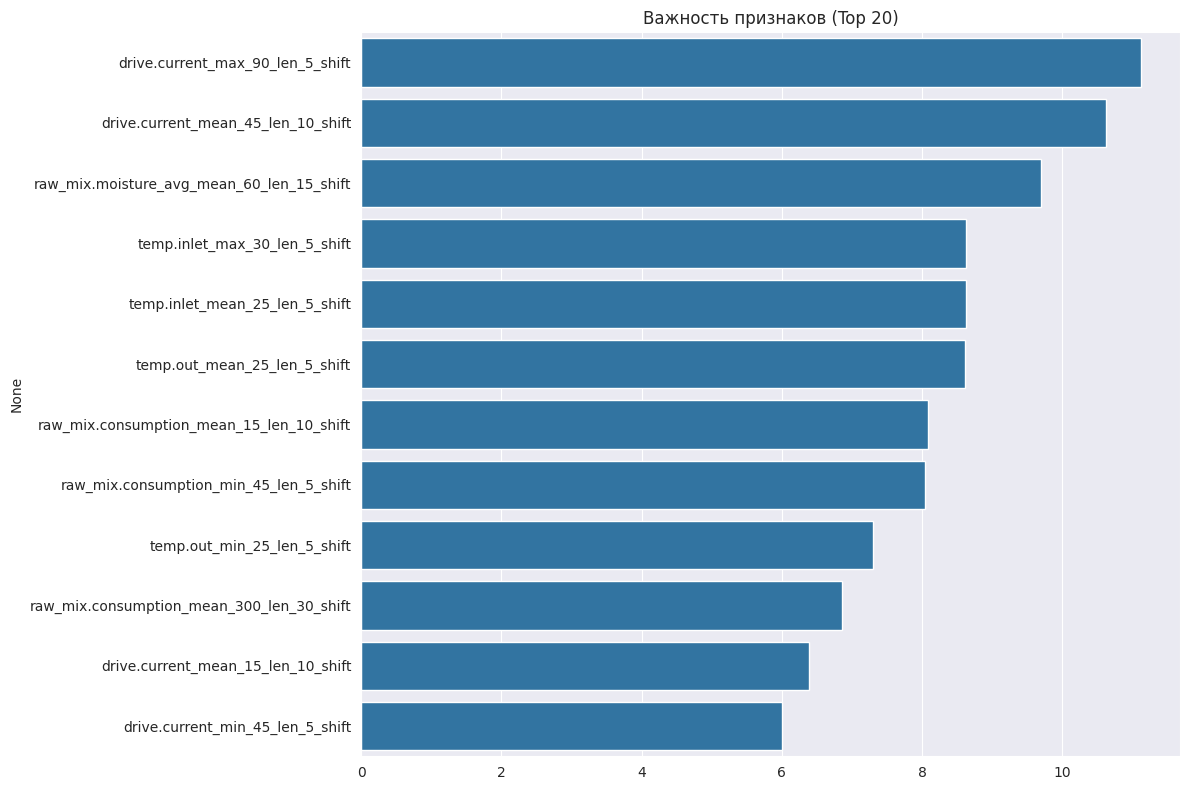

In [9]:
# Визуализация важности признаков
import seaborn as sns

feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:20]
fig = plt.figure(figsize=(12, 8))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Важность признаков (Top 20)')
plt.tight_layout()
plt.show()

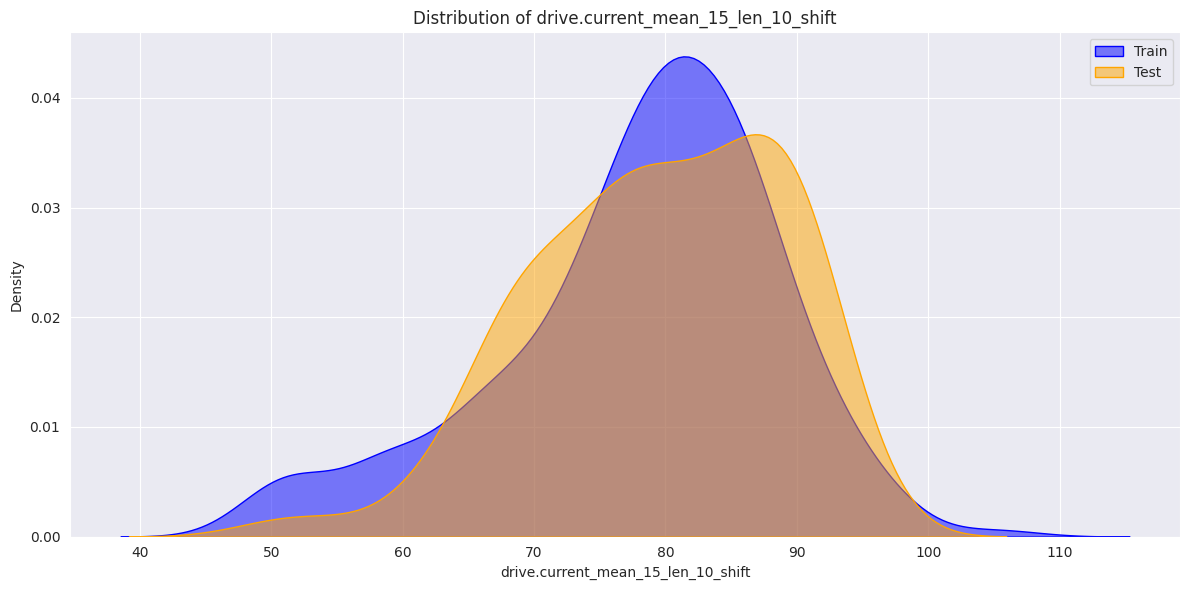

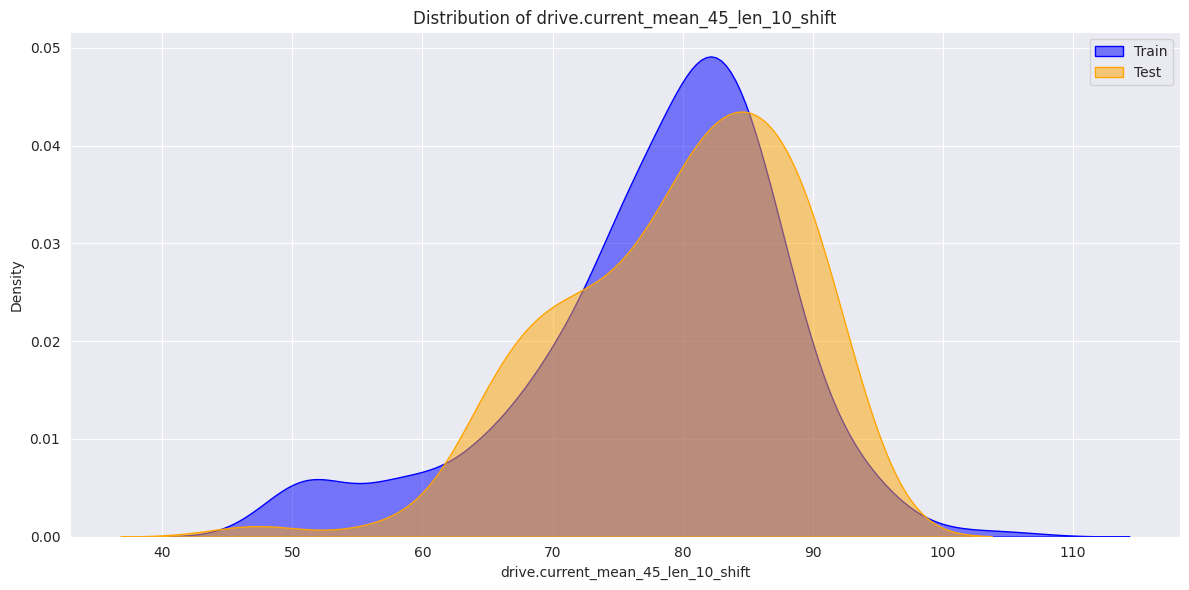

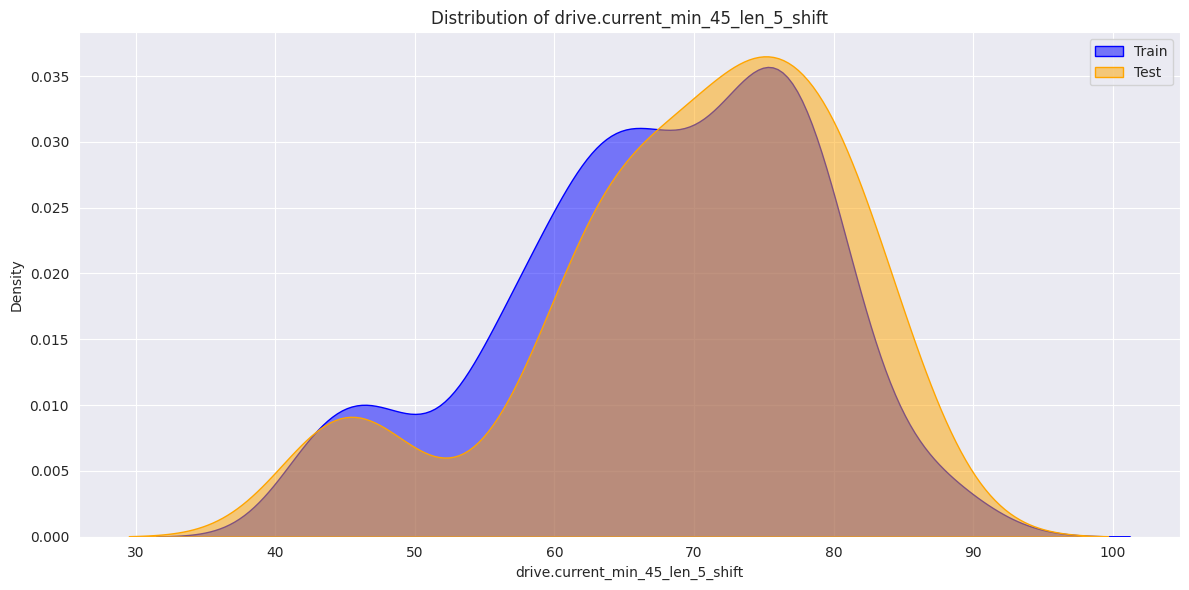

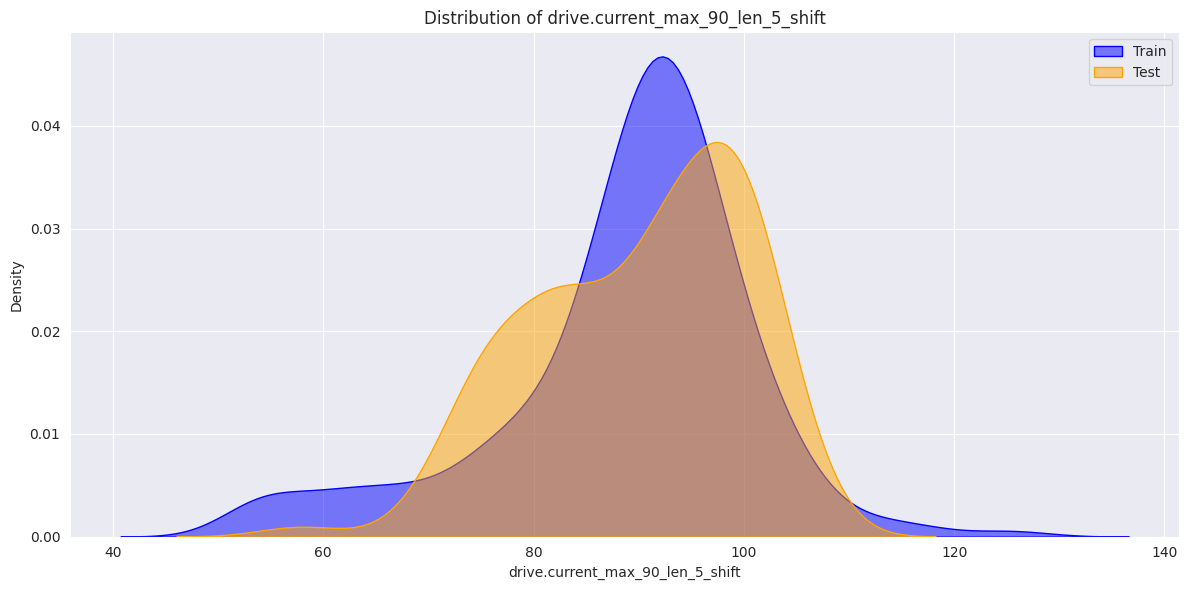

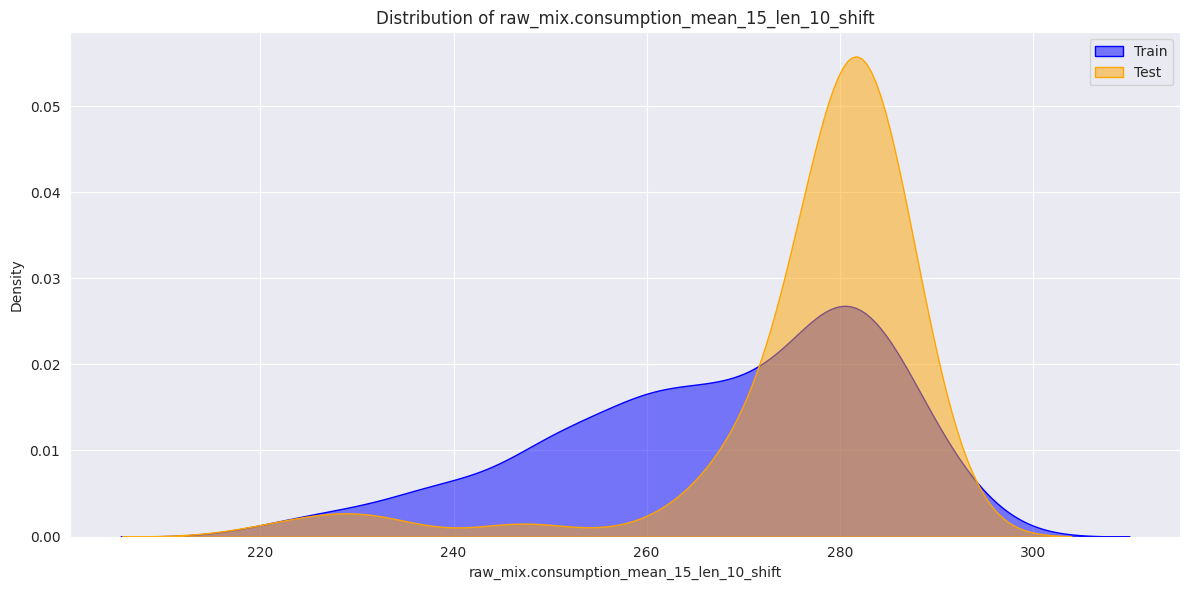

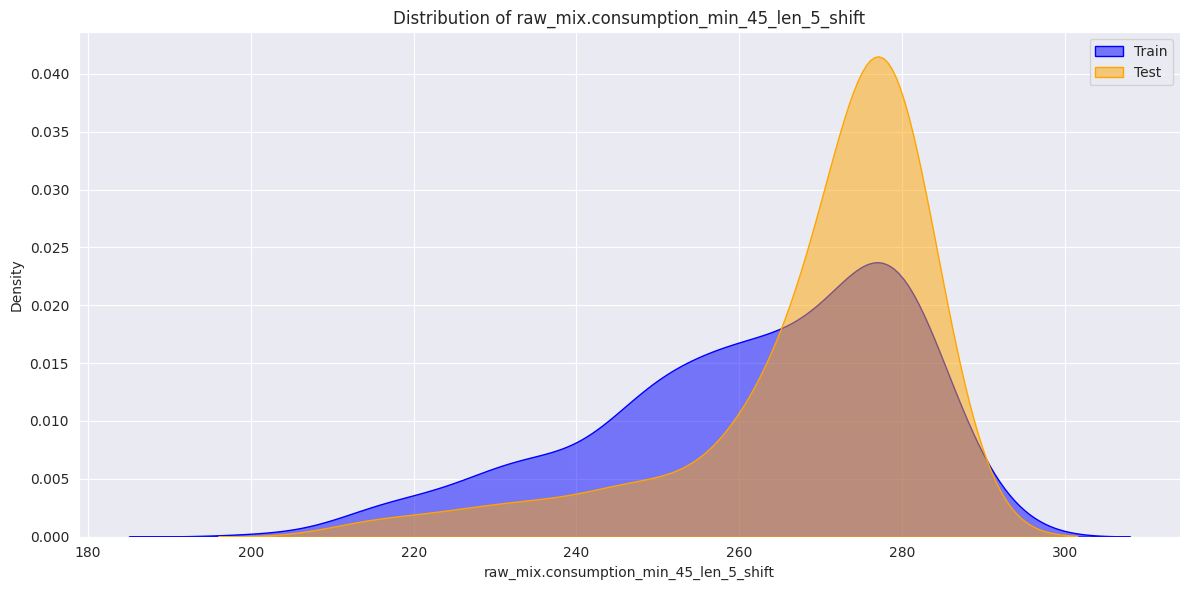

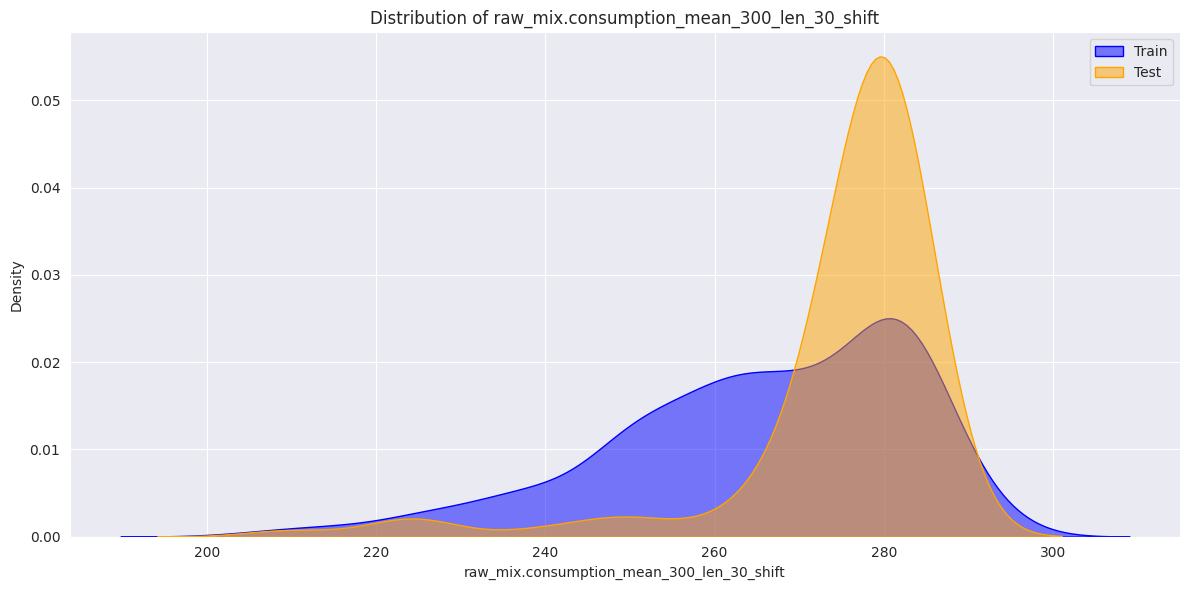

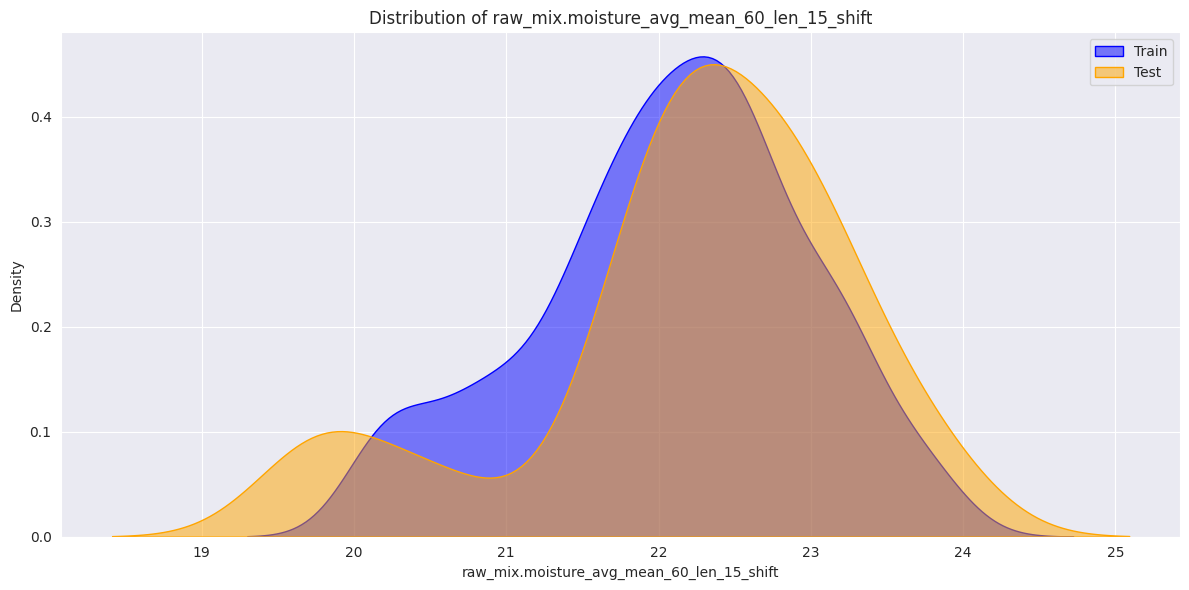

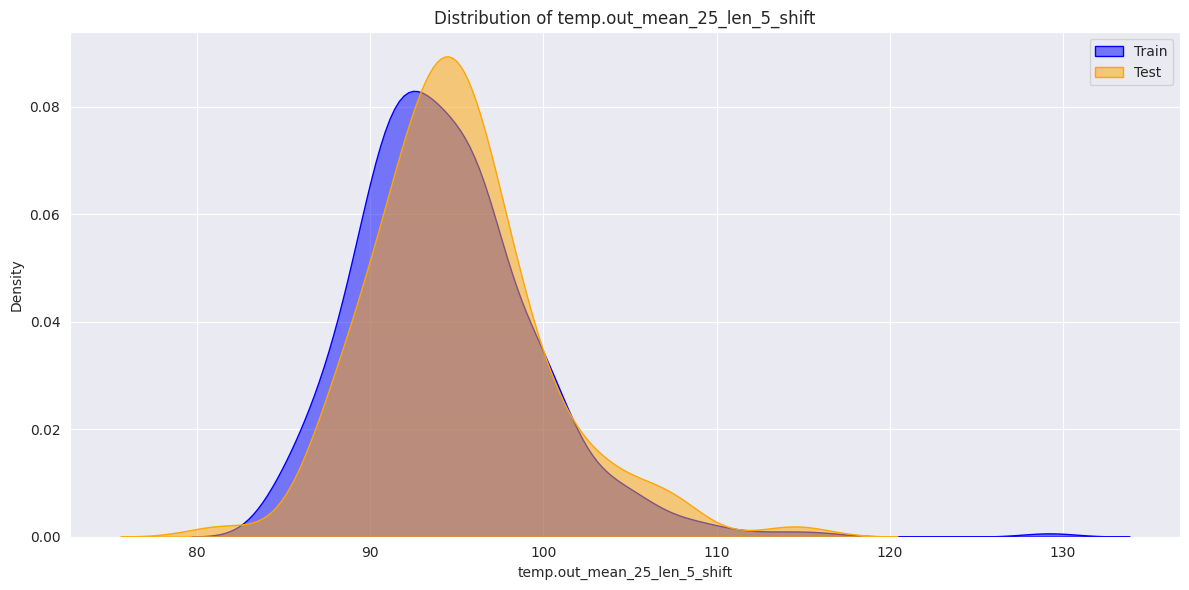

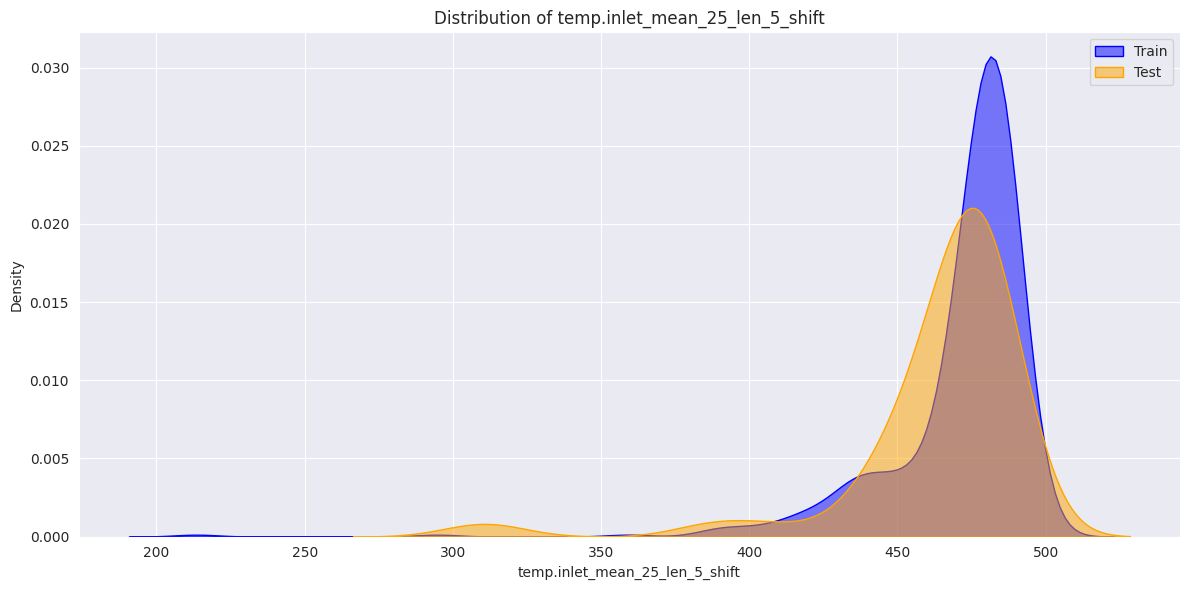

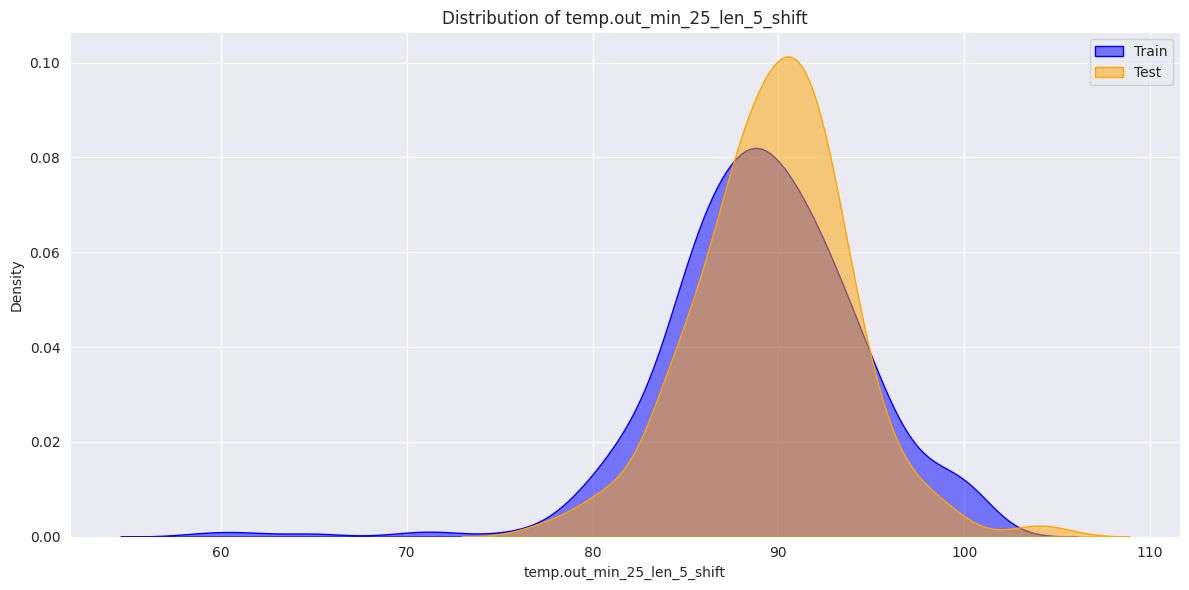

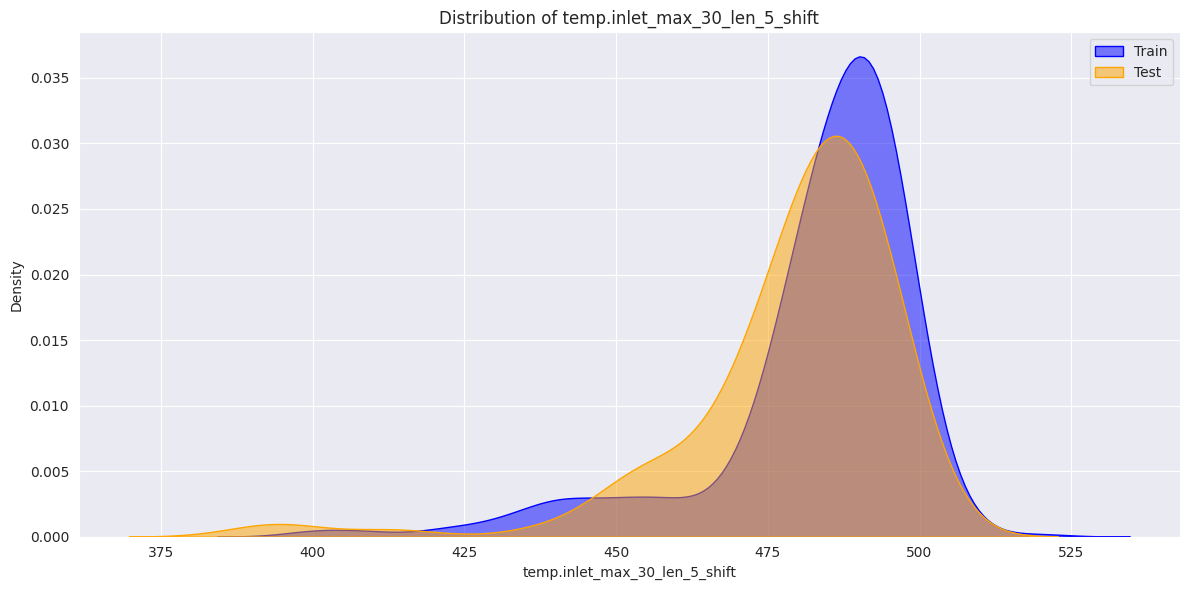

In [10]:
# Визуализация распределения признаков и целевой переменной
for feature in features:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=X_train[feature], label='Train', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(data=X_test[feature], label='Test', color='orange', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

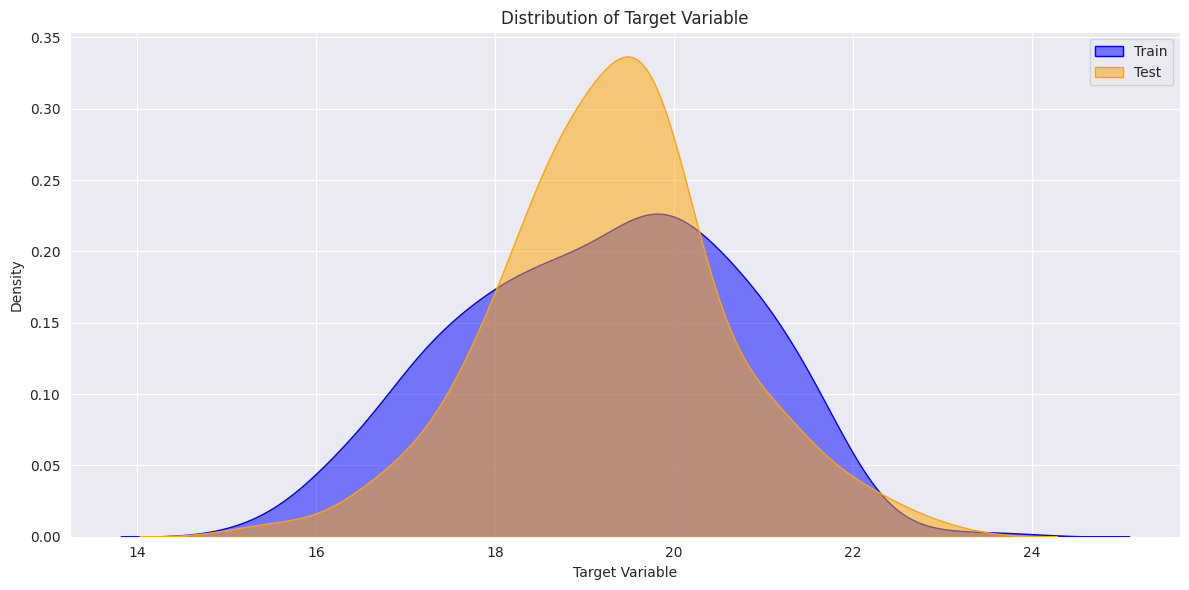

In [11]:
# График распределения целевой переменной
plt.figure(figsize=(12, 6))
sns.kdeplot(data=y_train, label='Train', color='blue', fill=True, alpha=0.5)
sns.kdeplot(data=y_test, label='Test', color='orange', fill=True, alpha=0.5)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()